In [3]:
import os
from sqlalchemy import create_engine
import dotenv
import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import tz

sns.set(style="darkgrid", palette="muted", color_codes=True)

In [4]:
# Load Database
dotenv.load_dotenv()
engine = create_engine(os.environ.get("POSTGRES_URI"), pool_pre_ping=True)

In [3]:
df = pd.read_sql(sqlalchemy.text("""
SELECT 
  timestamp, 
  potion_id,
  qty_change,
	CAST(SUM(qty_change)
	  OVER(PARTITION BY potion_id
        ORDER BY timestamp) AS INTEGER) AS qty_in_stock,
  potion_types.sku,
  (
    TO_CHAR(timestamp AT TIME ZONE 'America/Los_Angeles',
          'Mon dd - ')||
      (
      CAST(EXTRACT(hour from (timestamp AT TIME ZONE 'America/Los_Angeles')) AS INTEGER) / 2
      )
      ||' - '||
    TO_CHAR(DATE (timestamp AT TIME ZONE 'America/Los_Angeles'), 'Dy')
  ) AS date
FROM potion_ledger
INNER JOIN potion_types ON potion_ledger.potion_id = potion_types.id
GROUP BY potion_id, timestamp, qty_change, potion_types.sku
ORDER BY timestamp ASC
                                 """), engine)
df.head()

,timestamp,potion_id,qty_change,qty_in_stock,sku,date
0,2023-10-20 06:27:06.453888+00:00,4,5,5,RED,Oct 19 - 11 - Thu
1,2023-10-20 08:34:05.327188+00:00,4,-5,0,RED,Oct 20 - 0 - Fri
2,2023-10-20 14:22:05.472653+00:00,4,10,10,RED,Oct 20 - 3 - Fri
3,2023-10-20 16:38:05.403714+00:00,4,-3,7,RED,Oct 20 - 4 - Fri
4,2023-10-20 16:38:05.408494+00:00,4,-2,5,RED,Oct 20 - 4 - Fri


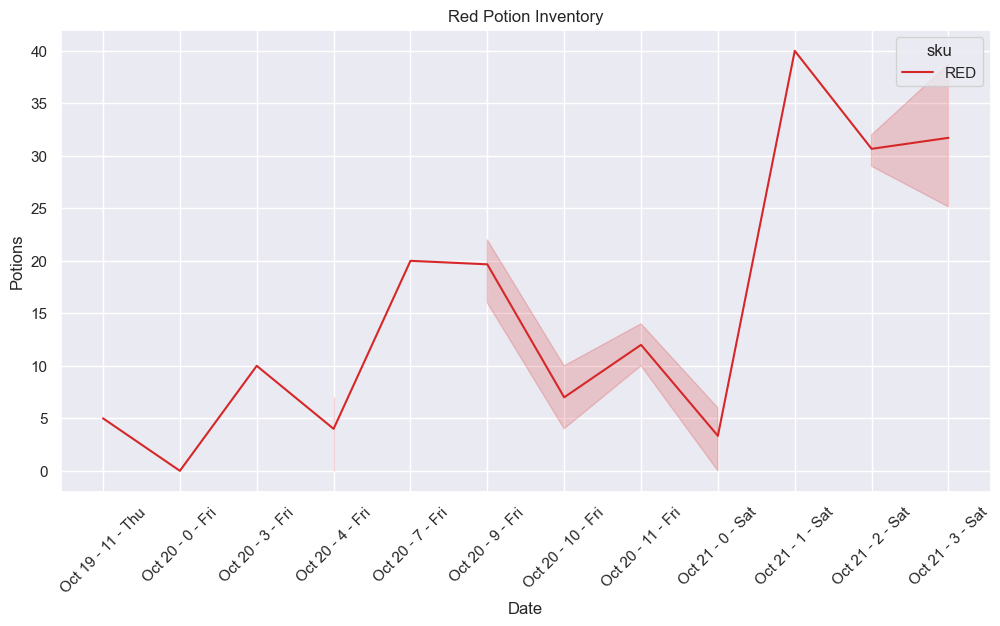

In [4]:
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(data=df[df['sku'] == "RED"],hue='sku', x='date', y='qty_in_stock',palette=['tab:red'], ax=ax)
ax.set(xlabel='Date', ylabel='Potions', title='Red Potion Inventory')
# for label in ax.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)
_ = plt.xticks(rotation=45)

In [33]:
df2 = pd.read_sql(sqlalchemy.text("""
SELECT 
  sku, 
  quantity AS qty,
  (TO_CHAR(created_at AT TIME ZONE 'America/Los_Angeles',
          'HH24')::integer - 1) / 2 AS tick
FROM cart_contents
JOIN potion_types ON potion_types.id = cart_contents.potion_id
"""), engine)

df.head()


,sku,qty,tick
0,RED,1,9
1,RED,6,10
2,RED,6,10
3,RED,4,10
4,RED,6,11


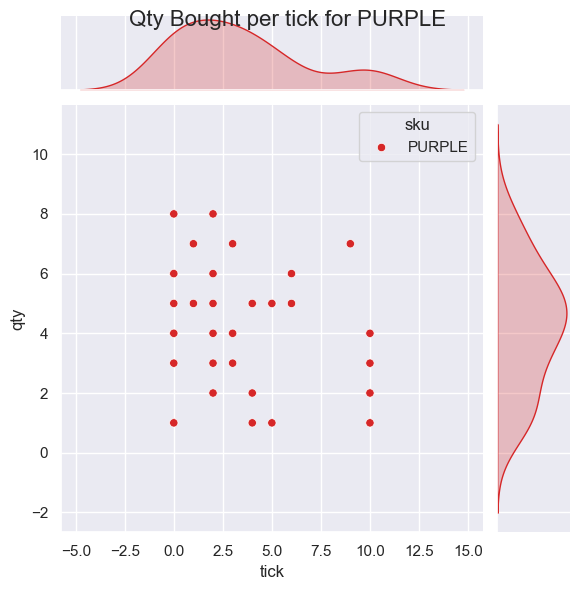

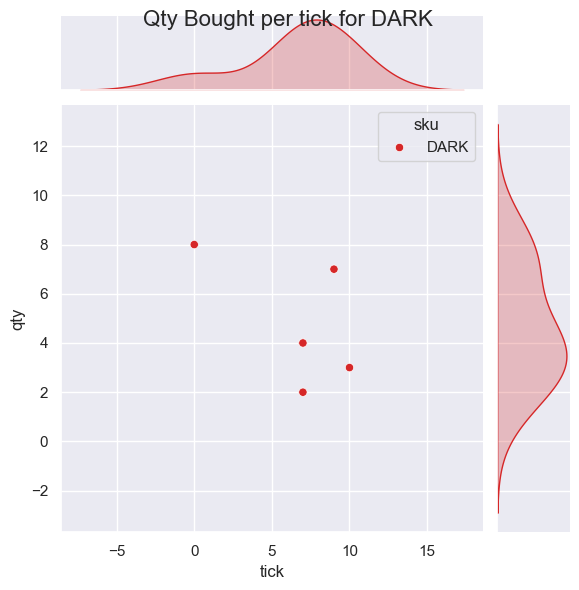

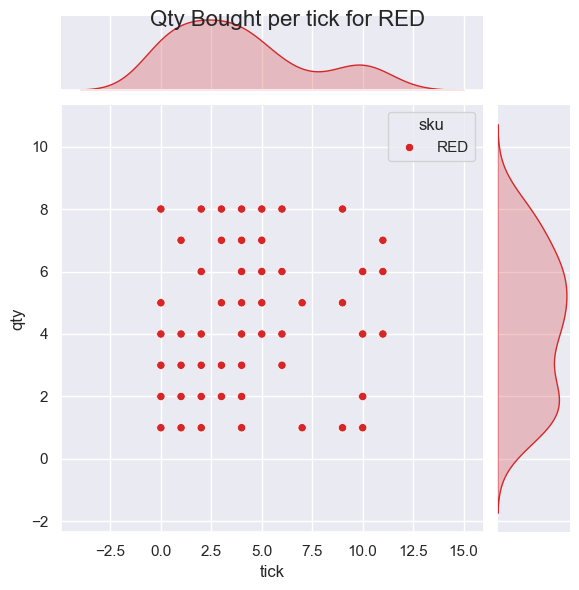

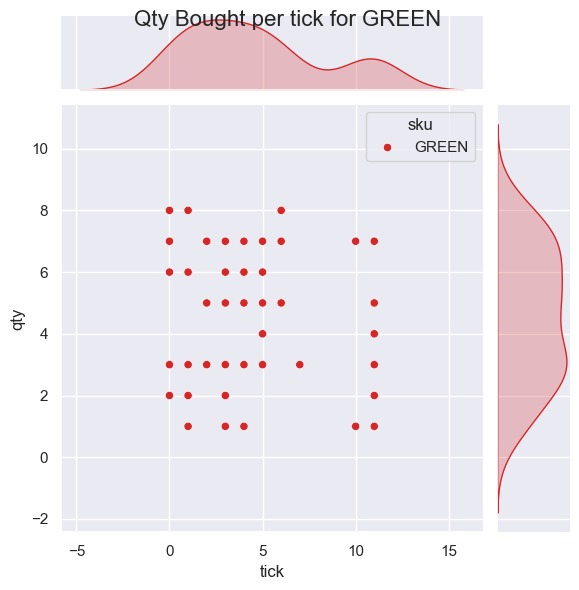

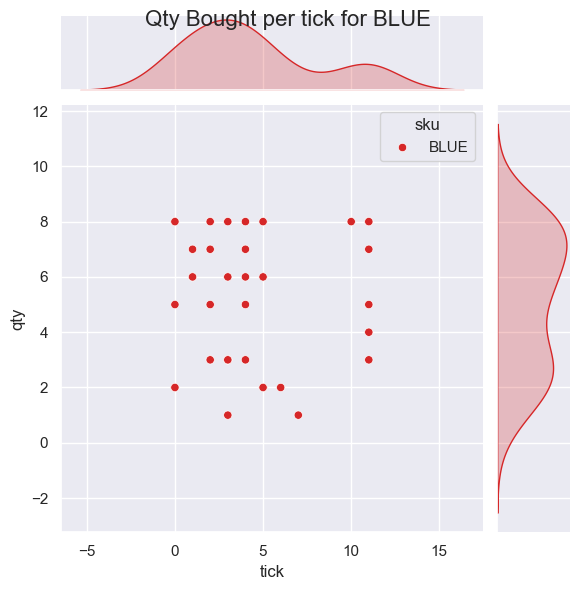

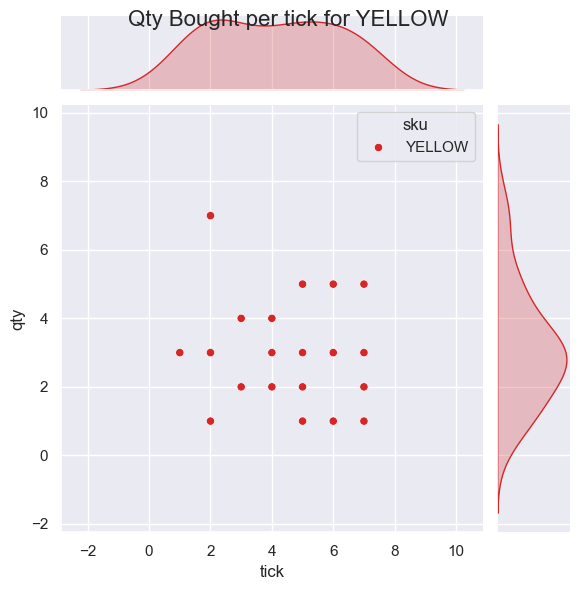

In [46]:
for x in df2["sku"].unique():
    p = sns.jointplot(data=df2[df2["sku"] == x], x='tick', y='qty', hue='sku', palette=['tab:red'])
    p.fig.suptitle(f'Qty Bought per tick for {x}', fontsize=16)


In [50]:
df3 = pd.read_sql(sqlalchemy.text("""
SELECT 
  sku, 
  quantity AS qty,
  extract(dow from created_at) as dow
FROM cart_contents
JOIN potion_types ON potion_types.id = cart_contents.potion_id
                                  """), engine)

df.head()


,sku,qty,tick
0,RED,1,9
1,RED,6,10
2,RED,6,10
3,RED,4,10
4,RED,6,11


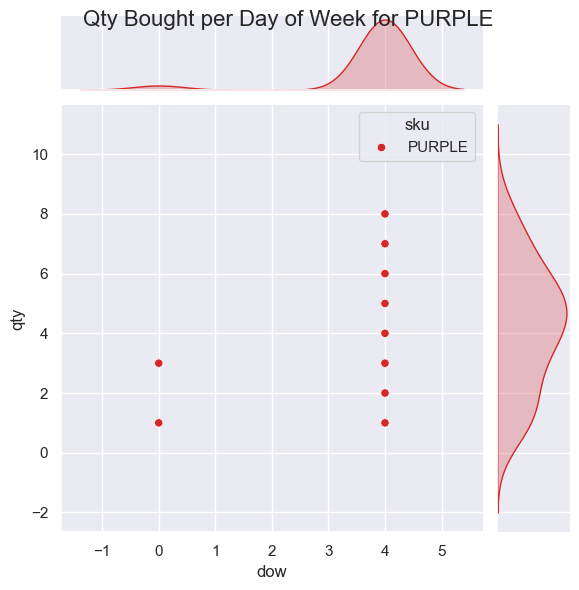

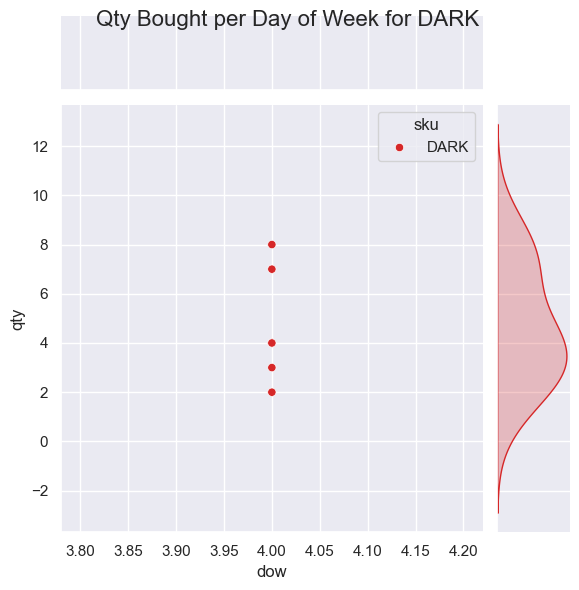

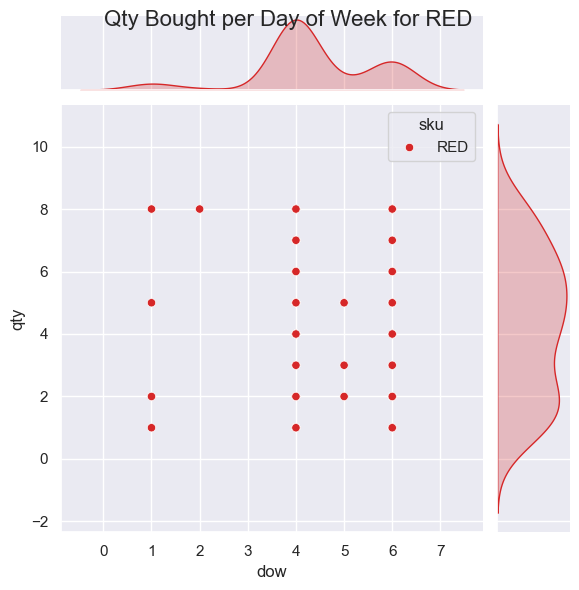

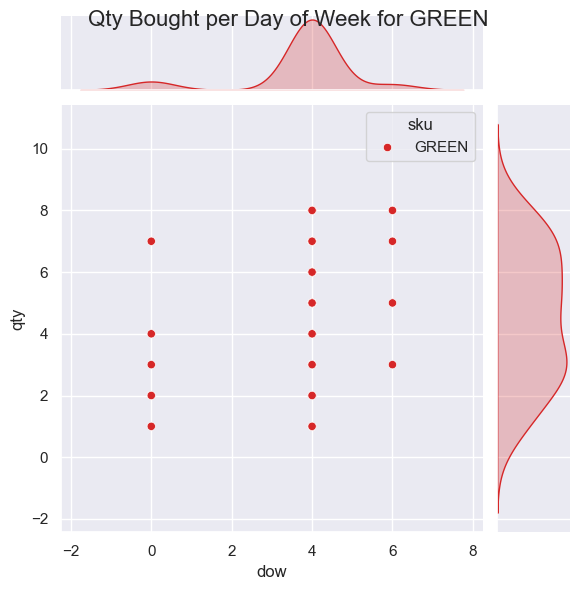

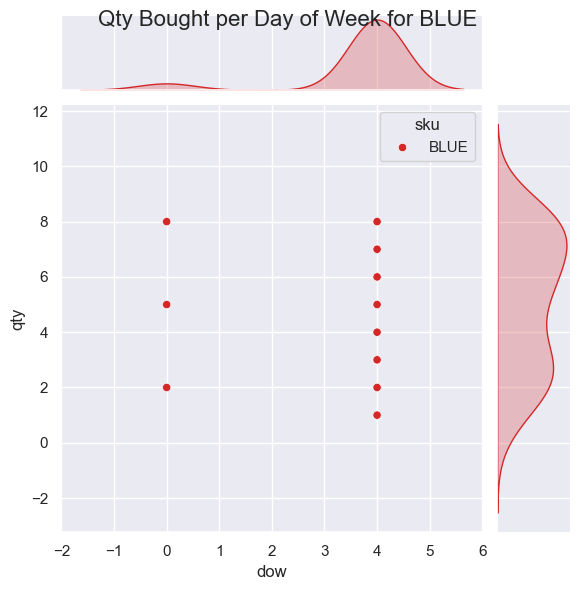

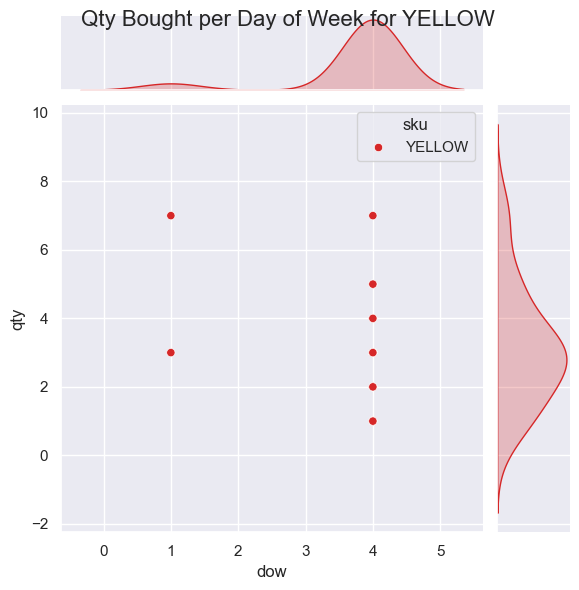

In [53]:
for x in df3["sku"].unique():
    p = sns.jointplot(data=df3[df3["sku"] == x], x='dow', y='qty', hue='sku', palette=['tab:red'])
    p.fig.suptitle(f'Qty Bought per Day of Week for {x}', fontsize=16)
